In [1]:
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

torch.set_printoptions(sci_mode = False, precision = 4)

In [2]:
# Hyperparameters
class HParams:
    def __init__(self):
        
        # Problem params
        self.num_agents = 2
        self.num_states = 2
        self.num_signals = 2
        
        self.alpha = 0.5
        
        # Minibatch size
        self.batch_size = 128
        
        # Number of samples for computing interim vals
        self.num_samples = 512
        
        # Number of layer
        self.R = 3
        # Number of hidden units
        self.K = 200
        
        # Data - Choose among exp, uniform, assymetric_uniform, irregular
        self.distr_type = "uniform"
        
        # Opt params
        self.lr = 1e-3
        
        self.gd_lr = 5e-3
        self.gd_iter = 0
        
        # Lagrangian params
        
        self.lag_ob_init = 10
        self.lag_ir_init = 10
        self.lag_ic_init = 10
        
        self.lag_up_iter = 100
        
        self.pho_init = 10
        
        self.pho_increment = 10
        self.pho_up_iter = 100
        
        # Miscellaneous
        self.seed = 0
                  
        self.max_iter = 10000 
        self.print_iter = 1000
                
# Initialize config
cfg = HParams()
np.random.seed(cfg.seed)

# Asserts
assert(cfg.num_agents == 2)
device = "cuda"

np.random.seed(cfg.seed)

In [3]:
def sample_batch(batch_size):
    return np.random.dirichlet([1,1], (batch_size))

In [4]:
# Utils
def torch_var(x): return torch.Tensor(x).to(device)
def numpy_var(x): return x.detach().cpu().numpy()

In [5]:
class PiNet(nn.Module):      
    def __init__(self, cfg):
        super(PiNet, self).__init__()
        self.cfg = cfg
        
        num_agents = self.cfg.num_agents
        num_states = self.cfg.num_states
        num_signals = self.cfg.num_signals
        
        num_layers = self.cfg.R
        num_hidden_nodes = self.cfg.K
        
        self.pi = nn.ModuleList()
        
        # Input layer
        m = nn.Linear(num_agents * num_states, num_hidden_nodes)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
        nn.init.constant_(m.bias, 0)
        self.pi.append(m)
        self.pi.append(nn.LeakyReLU())
        
        # Hidden layers
        for i in range(num_layers - 1):
            m = nn.Linear(num_hidden_nodes, num_hidden_nodes)
            nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
            nn.init.constant_(m.bias, 0)
            self.pi.append(m)
            self.pi.append(nn.LeakyReLU())
         
        # Output-1
        m = nn.Linear(num_hidden_nodes, num_agents * num_states * num_signals)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('sigmoid'))
        nn.init.constant_(m.bias, 0)
        self.experiment = m
        
    def forward(self, theta):

        out = theta.view(-1, cfg.num_agents * cfg.num_states)
        for module in self.pi: out = module(out)
        
        # pi
        pi = self.experiment(out).view(-1, self.cfg.num_agents, self.cfg.num_states, self.cfg.num_signals)
        pi =  F.softmax(5 * pi, dim = -1)

        
        return pi
        
class PayNet(nn.Module):     
    def __init__(self, cfg):
        super(PayNet, self).__init__()
        self.cfg = cfg        
        num_layers = self.cfg.R
        num_hidden_nodes = self.cfg.K
        num_states = self.cfg.num_states

        self.pay = nn.ModuleList()
        
        # Input layer
        m = nn.Linear(num_states, num_hidden_nodes)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
        nn.init.constant_(m.bias, 0)
        self.pay.append(m)
        self.pay.append(nn.LeakyReLU())
        
        # Hidden layers
        for i in range(num_layers - 1):
            m = nn.Linear(num_hidden_nodes, num_hidden_nodes)
            nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
            nn.init.constant_(m.bias, 0)
            self.pay.append(m)
            self.pay.append(nn.LeakyReLU())
         
        # Output layer
        self.pay.append(nn.Linear(num_hidden_nodes, 1))
        self.pay.append(nn.Sigmoid())
        
        for m in self.pay:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
                nn.init.constant_(m.bias, 0)
        
    def forward(self, theta):
        out = theta
        for module in self.pay: out = module(out)
        return out.flatten()

In [6]:
pi_net = PiNet(cfg).to(device)
pay_net = PayNet(cfg).to(device)
# Keep in mind that if the distributions are asymetric, we need two different neural networks

In [7]:
def compute_ob_viol(theta, pi):
    pt = pi * theta[..., None]
    x = torch.diagonal(pt, offset = 0, dim1 = -2, dim2 = -1).sum(-1)
    x_deviation = torch.max(pt, axis = -2)[0].sum(axis = -1)
    return F.relu(x_deviation - x).mean(axis = 0)

In [8]:
lag_ob_init = cfg.lag_ob_init
lag_ir_init = cfg.lag_ir_init
lag_ic_init = cfg.lag_ic_init

pho = cfg.pho_init
pho_increment = cfg.pho_increment

w_ob = torch.ones(cfg.num_agents).to(device) * lag_ob_init
w_ir = torch.ones(cfg.num_agents).to(device) * lag_ir_init
w_ic = torch.ones(cfg.num_agents).to(device) * lag_ic_init

opt = torch.optim.AdamW(list(pi_net.parameters()) + list(pay_net.parameters()), lr=cfg.lr)

it = 0

In [9]:
"""
V_sample is a tensor of shape [num_agents, batch_size and num_samples].
V_sample[i, :, :] contains 'num_samples' samples of agent i's valuation to be averaged over 
for the computation of interim values of the remaning agents. These samples are the same 
for every valuation profile in the minibatch. (i.e V[i, j, :] = V[i, k, :] )
"""
THETA_sample = np.zeros((cfg.num_agents, cfg.batch_size, cfg.num_samples, cfg.num_states))

for i in range(cfg.num_agents):
    THETA_sample[i] = np.tile(sample_batch(cfg.num_samples)[None, :, :], (cfg.batch_size, 1, 1))

In [10]:
import time
tic = time.time()
                                  
while it <= cfg.max_iter:
    
    
    opt.zero_grad()
    
    """ 
    Construction of V_mesh:
    V_mesh is of shape [num_agents, batch_size, num_samples, num_agents]
    What's V_mesh[i, j, k, l]?
    V[i, j] - has num_samples elements with the same valuation for agent - i
    but with num_samples values from the V_sample array for other agents
    
    We use this for computation of payment, ic-viol, ob-viol for agent - i only
    """
    
    
    THETA = np.zeros((cfg.num_agents, cfg.batch_size, cfg.num_states))
    THETA_mesh = np.zeros((cfg.num_agents, cfg.batch_size, cfg.num_samples, cfg.num_agents, cfg.num_states))


    for i in range(cfg.num_agents):
        THETA[i] = sample_batch(cfg.batch_size)
        
        for j in range(cfg.num_agents):
            if i == j:    
                THETA_mesh[i, :, :, i, :] = np.tile(THETA[i][:, None, :], (1, cfg.num_samples, 1))
            else:
                THETA_mesh[i, :, :, j] = THETA_sample[j]
           
    theta = torch_var(THETA)
    theta_mesh = torch_var(THETA_mesh)
    
    pi_mesh = pi_net(theta_mesh.view(-1, cfg.num_agents, cfg.num_states))
    pi_mesh = pi_mesh.view(cfg.num_agents, cfg.batch_size, cfg.num_samples, cfg.num_agents, cfg.num_states, cfg.num_signals).mean(axis = -4)
        
    revenue = torch.zeros(cfg.num_agents).to(device)
    ob_viol = torch.zeros(cfg.num_agents).to(device)
    ir_viol = torch.zeros(cfg.num_agents).to(device)
    ic_viol = torch.zeros(cfg.num_agents).to(device)
    
    
    
    for i in range(cfg.num_agents):
                
        
        # BS, NA, NS, NSi
        pi_interim = pi_mesh[i, :, i]
        pj_interim = pi_mesh[i, :, 1 - i]
        
        xi_interim = torch.diagonal(pi_interim * theta[i][..., None], offset = 0, dim1 = -2, dim2 = -1).sum(-1)
        xj_interim = torch.diagonal(pj_interim * theta[i][..., None], offset = 0, dim1 = -2, dim2 = -1).sum(-1)
        
        u_in = xi_interim - cfg.alpha * xj_interim
        u_out = theta[i].max(axis = -1)[0] - cfg.alpha
        
        pay_frac = pay_net(theta[i])
        pay_interim = pay_frac * (u_in - u_out)
         
        # Compute Revenue        
        revenue[i] = pay_interim.mean()
        
        # Compute IR viol: already satisfied
        
        # Compute OB viol
        xi_deviation = torch.max(pi_interim * theta[i][..., None], axis = -2)[0].sum(axis = -1)
        ob_viol[i] = F.relu(xi_deviation - xi_interim).mean()
        
        
        # Compute IC viol        
        xi_mesh = torch.diagonal(theta[i][:, None, :, None] * pi_interim[None, :, :, :], offset = 0, dim1 = -2, dim2 = -1).sum(-1)
        xj_mesh = torch.diagonal(theta[i][:, None, :, None] * pj_interim[None, :, :, :], offset = 0, dim1 = -2, dim2 = -1).sum(-1)
        u_mesh = xi_mesh - cfg.alpha * xj_mesh - pay_interim[None, :]
        ic_viol[i] = F.relu(u_mesh.max(axis = -1)[0] - torch.diag(u_mesh)).mean()
       
    rev_loss = -revenue.sum()
    lagrangian = torch.dot(w_ob, ob_viol) + torch.dot(w_ir, ir_viol) + torch.dot(w_ic, ic_viol)
    penalty = pho * ((ob_viol**2).sum() + (ir_viol**2).sum() + (ic_viol**2).sum())
    
    loss = rev_loss + penalty + lagrangian
    
    loss.backward()   
    opt.step()
    
    if it % cfg.print_iter == 0:
        print("[Iter: %d], [Time Elapsed: %.2fs]"%(it, time.time() - tic))
        print("[Rev: %.4f], [OB Viol: %.4f], [IR Viol: %.4f], [IC Viol: %.4f]"%(revenue.sum(), ob_viol.mean().item(), ir_viol.mean().item(), ic_viol.mean().item()))
        
    if it % cfg.lag_up_iter == 0:
        w_ob.data += pho * ob_viol.data
        w_ir.data += pho * ir_viol.data
        w_ic.data += pho * ic_viol.data
        
    if it % cfg.pho_up_iter == 0:
        pho += pho_increment
        
    it += 1

[Iter: 0], [Time Elapsed: 0.35s]
[Rev: 0.0420], [OB Viol: 0.1917], [IR Viol: 0.0000], [IC Viol: 0.2079]
[Iter: 1000], [Time Elapsed: 17.92s]
[Rev: 0.6182], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0004]
[Iter: 2000], [Time Elapsed: 35.31s]
[Rev: 0.6292], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0002]
[Iter: 3000], [Time Elapsed: 52.70s]
[Rev: 0.5941], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0002]
[Iter: 4000], [Time Elapsed: 70.09s]
[Rev: 0.6209], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0002]
[Iter: 5000], [Time Elapsed: 87.60s]
[Rev: 0.5908], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0001]
[Iter: 6000], [Time Elapsed: 105.01s]
[Rev: 0.6235], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0001]
[Iter: 7000], [Time Elapsed: 122.41s]
[Rev: 0.6183], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0001]
[Iter: 8000], [Time Elapsed: 139.88s]
[Rev: 0.6107], [OB Viol: 0.0000], [IR Viol: 0.0000], [IC Viol: 0.0001]
[Iter: 9000], [Time Elapsed: 

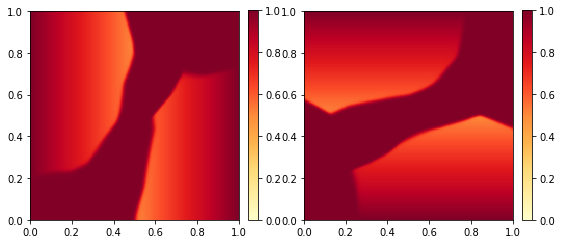

In [11]:
D = 201
t = np.linspace(0, 1, D)
THETA = np.array(np.meshgrid(t, t)).T[..., None]
THETA = np.tile(THETA, (1, 1, 1, 2))
THETA[..., 1] = 1 - THETA[..., 0]


theta = torch_var(THETA)

pi = pi_net(theta.view(-1, 2, 2))
x = torch.diagonal(pi * theta.view(-1, 2, 2, 1), offset = 0, dim1 = -2, dim2 = -1).sum(-1).view(D, D, 2)
X = numpy_var(x)

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(9,4))

img_1 = ax[0].imshow(X[:, :, 0].transpose(1,0), extent=[0,1,0,1], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd', origin = "lower")
plt.colorbar(img_1, ax = ax[0], fraction=0.046, pad=0.04)

img_2 = ax[1].imshow(X[:, :, 1].transpose(1,0), extent=[0,1,0,1], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd', origin = "lower")
plt.colorbar(img_2, ax = ax[1], fraction=0.046, pad=0.04)

In [12]:
num_tst_batches = 160
with torch.no_grad():
    rev_total = 0.0
    for _ in range(num_tst_batches):

        THETA = np.zeros((cfg.num_agents, cfg.batch_size, cfg.num_states))
        THETA_mesh = np.zeros((cfg.num_agents, cfg.batch_size, cfg.num_samples, cfg.num_agents, cfg.num_states))


        for i in range(cfg.num_agents):
            THETA[i] = sample_batch(cfg.batch_size)

            for j in range(cfg.num_agents):
                if i == j:    
                    THETA_mesh[i, :, :, i, :] = np.tile(THETA[i][:, None, :], (1, cfg.num_samples, 1))
                else:
                    THETA_mesh[i, :, :, j] = THETA_sample[j]

        theta = torch_var(THETA)
        theta_mesh = torch_var(THETA_mesh)

        pi_mesh = pi_net(theta_mesh.view(-1, cfg.num_agents, cfg.num_states))
        pi_mesh = pi_mesh.view(cfg.num_agents, cfg.batch_size, cfg.num_samples, cfg.num_agents, cfg.num_states, cfg.num_signals).mean(axis = -4)

        revenue = torch.zeros(cfg.num_agents).to(device)

        for i in range(cfg.num_agents):


            # BS, NA, NS, NSi
            pi_interim = pi_mesh[i, :, i]
            pj_interim = pi_mesh[i, :, 1 - i]

            xi_interim = torch.diagonal(pi_interim * theta[i][..., None], offset = 0, dim1 = -2, dim2 = -1).sum(-1)
            xj_interim = torch.diagonal(pj_interim * theta[i][..., None], offset = 0, dim1 = -2, dim2 = -1).sum(-1)

            u_in = xi_interim - cfg.alpha * xj_interim
            u_out = theta[i].max(axis = -1)[0] - cfg.alpha

            pay_frac = pay_net(theta[i])
            pay_interim = pay_frac * (u_in - u_out)

            # Compute Revenue        
            revenue[i] = pay_interim.mean()


        rev_total += revenue.sum().item()
    print(rev_total/num_tst_batches)

0.6134915433824062
